<a href="https://colab.research.google.com/github/Shobhit2000/Depth_Map_Construction/blob/master/Depth_Map_Construction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat

--2020-06-26 21:29:28--  http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat
Resolving horatio.cs.nyu.edu (horatio.cs.nyu.edu)... 216.165.22.17
Connecting to horatio.cs.nyu.edu (horatio.cs.nyu.edu)|216.165.22.17|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2971894459 (2.8G)
Saving to: ‘nyu_depth_v2_labeled.mat’

nyu_depth_v2_labele 100%[===================>]   2.77G  90.6MB/s    in 33s     

2020-06-26 21:30:03 (85.4 MB/s) - ‘nyu_depth_v2_labeled.mat’ saved [2971894459/2971894459]



In [2]:
import tensorflow as tf

import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from PIL import Image
!pip install pymatreader
from pymatreader import read_mat

from keras.layers import Dense, Input, Conv2D, Flatten, Reshape
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.utils import plot_model
from keras import backend as K

  Created wheel for pymatreader: filename=pymatreader-0.0.23-cp36-none-any.whl size=8517 sha256=d99f9a7a348bf12c3ea4caeb7569555faa805f2383159ec78984772d1edf35dc
  Stored in directory: /root/.cache/pip/wheels/da/c3/f8/2d3d17ddee1e38163a3b456691782953d5d5e30081d526e214
Successfully built pymatreader


Using TensorFlow backend.


**Load Data**

In [3]:
data = read_mat('/content/nyu_depth_v2_labeled.mat')

/usr/local/lib/python3.6/dist-packages/pymatreader/utils.py:118: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


In [4]:
depths = data['depths']
images = data['images']

depths = np.asarray(depths)
images = np.asarray(images)

In [5]:
print(depths.shape)
print(images.shape)

(480, 640, 1449)
(480, 640, 3, 1449)


**Create Training datasets**

In [6]:
X_train = [images[:, :, :, 0]]

for i in range(1, 1001):
  a = images[:, :, :, i]
  X_train.append(a)

X_train = np.asarray(X_train)
print(X_train.shape)

(1001, 480, 640, 3)


In [7]:
Y_train = [depths[:, :, 0]]

for i in range(1, 1001):
  a = depths[:, :, i]
  Y_train.append(a)

Y_train = np.asarray(Y_train)
print(Y_train.shape)

(1001, 480, 640)


**Visualize Data**

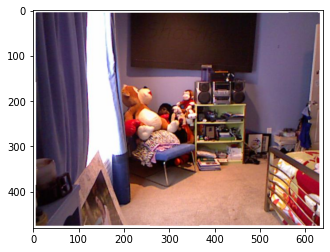

In [8]:
plt.imshow(X_train[1000])
plt.show()

In [9]:
print(Y_train[1000][50][300]) # distance of wall from the camera 
print(Y_train[1000][450][350]) # distance of couch from the camera 

3.403007
2.2560542


In [10]:
print(np.max(depths)) # maximum value of distance 

9.99547


**Normalize the X and Y data**

In [ ]:
X_train = X_train/255
Y_train = Y_train/10

**Train Test split**

In [ ]:
X_test = X_train[900:]
Y_test = Y_train[900:]

X_train = X_train[:900]
Y_train = Y_train[:900]

**Define Network Parameters**

In [ ]:
inp_dim = (480, 640, 3)
out_dim = (480, 640, 1)

**Model**

In [ ]:
inputs = Input(shape=inp_dim)
x = inputs
x = Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3), strides=2, activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dense(307200, name='latent_vector')(x)
output = Reshape(out_dim)(x)

In [ ]:
model = Model(inputs, output, name='depth_model')

In [ ]:
model.summary()

In [ ]:
model.compile(loss = 'mse', optimizer = 'Adam', metrics = ['accuracy'])

In [ ]:
model.fit(X_train, Y_train, validation_data = (X_test, Y_test),epochs = 100, batch_size = 10)